## TFRecord files Explorer

Reads a set of images packed in TFRecord files and displays them

This code has been largely inspired by the example at: https://keras.io/examples/keras_recipes/tfrecord/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
import re, math
import matplotlib.pyplot as plt

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    print('working on TPU...')
except:
    strategy = tf.distribute.get_strategy()
    
    print('working on CPU/GPU...')
    
print("Number of replicas:", strategy.num_replicas_in_sync)

working on CPU/GPU...
Number of replicas: 1


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# this way works even with TPU (where you can't refer local FS)
GCS_PATH = './tfrec'

BATCH_SIZE = 25

IMAGE_SIZE = [512, 512]

In [4]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/train*.tfrec")
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/test*.tfrec")

print("Train-validation TFRecord Files:", len(TRAINING_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train-validation TFRecord Files: 13
Test TFRecord Files: 4


In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

n_train = count_data_items(TRAINING_FILENAMES)
n_test = count_data_items(TEST_FILENAMES)

print('Number of train-validation images:', n_train)
print('Number of test images:', n_test)

Number of train-validation images: 2544
Number of test images: 636


In [6]:
# we assume here that in TFRecords file images are JPEG, 256x256, 3 channel

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    # normalize pixels
    image = image/255.
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [7]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    
    image = decode_image(example["image"])
    
    if labeled:
        label = tf.cast(example["label"], tf.int32)
        return image, label
    return image

In [8]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [9]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [10]:
train_dataset = get_dataset(TRAINING_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES)

In [11]:
image_batch, label_batch = next(iter(test_dataset))

In [12]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16, 16))
    
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        
        if label_batch[n]:
            plt.title("Pneumonia")
        else:
            plt.title("Not pneumonia")
        plt.axis("off")

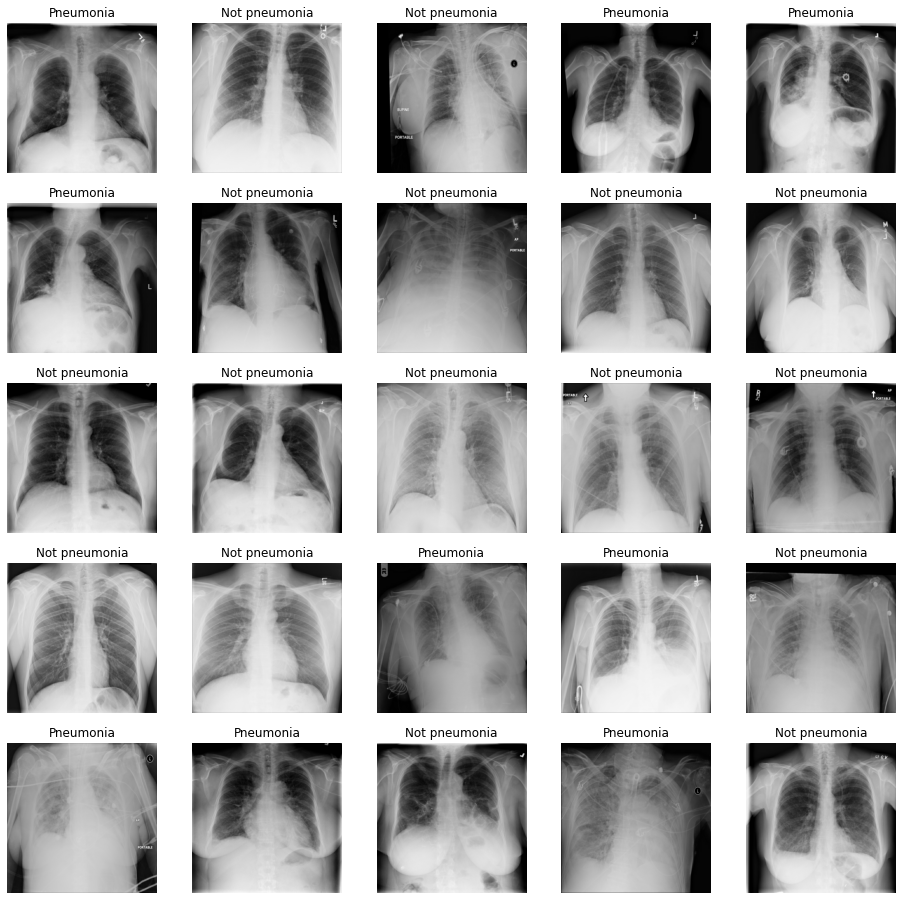

In [13]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
# this way I iterate on the TEST DS
n_step = int(n_test/BATCH_SIZE)

iter_test = iter(test_dataset)

for step in range(0, n_step):
    image_batch, label_batch = next(iter_test)
    
    print(label_batch.numpy())
    print(image_batch.shape)
    print(label_batch.numpy().shape)

[0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0]
(25, 512, 512, 3)
(25,)
[1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0]
(25, 512, 512, 3)
(25,)
[0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
(25, 512, 512, 3)
(25,)
[0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0]
(25, 512, 512, 3)
(25,)
[0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
(25, 512, 512, 3)
(25,)
[1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
(25, 512, 512, 3)
(25,)
[0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0]
(25, 512, 512, 3)
(25,)
[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0]
(25, 512, 512, 3)
(25,)
[0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0]
(25, 512, 512, 3)
(25,)
[1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0]
(25, 512, 512, 3)
(25,)
[1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1]
(25, 512, 512, 3)
(25,)
[0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1]
(25, 512, 512, 3)
(25,)
[0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0]
(25, 512, 512, 3)
(25,)
[0 1 0 0 0 0